In [1]:
import sys
import os
# Appending python modules so we can run simulations
sys.path.append("../python")
import utility
import models
import pandas as pd
import seaborn as sns
import importlib
import matplotlib.pyplot as plt
from pymunk.vec2d import Vec2d
from pilot4 import generate_stimuli_from_types_json

pygame 2.1.2 (SDL 2.0.18, Python 3.9.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def get_scene_type(scene_name):
    '''
    Returns the scene type for a given scene name.
    '''
    split_name = scene_name.split('_')[:2]
    return '_'.join(split_name)

In [3]:
def get_scene_name(file_name):
    '''
    Returns scene name from file name
    '''
    return file_name.split(".")[0]

In [4]:
types = "../data/json/pilot7/types/"
savedir = "../data/json/pilot7/"

In [5]:
generate_stimuli_from_types_json(types,savedir,False)

In [5]:
# Director with relevant JSONs
# loaddir = "../../../Desktop/new_types/"
# loaddir = "../../../Desktop/pilot7/"
loaddir = "../data/json/pilot4/trial/"
# loaddir = "../data/json/pilot7/"
# Gather all of the json files in the directory of trial stimuli
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [6]:
# Dictionary that will contain distance travelled per scenario 
distances = []

# Iterate through stimuli files
for scene_json in json_files:
    scene_dir = loaddir+scene_json
    scene_name = get_scene_name(scene_json)
    scene = utility.load_scene(scene_dir)
    # Extract the origin (the ball's starting position)
    origin = scene.args['ball_args'][0]
    # Extract the goal position
    goal = scene.args['goal_args'][0]
    # Convert these points into Vec2d for compatibility with pymunk
    origin = Vec2d(*origin)
    goal = Vec2d(*goal)
    dist = {}
    # Compute the distance
    dist['distance'] = origin.get_distance(goal)
    # Add the scene, distance pair into the dataframe
    dist['scene'] = scene_name
    distances.append(dist)

In [7]:
distances = pd.DataFrame.from_dict(distances)

In [29]:
simulation_rt = []
abstraction_rt = []
for scene_json in json_files:
    scene_dir = loaddir+scene_json
    scene_name = get_scene_name(scene_json)
    if 'negative' in scene_name:
        collision = False
    else:
        collision = True
    scene_type = get_scene_type(scene_name)
    # Samples to draw from models
    samples = 1000
    # Noise (SD on ball starting pos) for simulation model
    noise = 0.02
    # Generate a scene
    scene = utility.load_scene(scene_dir)
    # Get RT profile from model
    ## Simulation
    simulation_sample = models.simulation(scene.args,num_samples=samples,noise=noise)
    simulation_sample['scene'] = scene_name
    simulation_sample['scene_type'] = scene_type
    simulation_sample['collision'] = collision
    simulation_rt.append(simulation_sample)
    ## Abstraction
    abstraction_sample = models.abstraction(scene_args=scene.args,num_samples=samples)
    abstraction_sample['scene'] = scene_name
    abstraction_sample['scene_type'] = scene_type
    abstraction_sample['collision'] = collision
    abstraction_rt.append(abstraction_sample)

KeyboardInterrupt: 

In [57]:
simulation_rt = []
for scene_json in json_files:
    scene_dir = loaddir+scene_json
    scene_name = get_scene_name(scene_json)
    if 'negative' in scene_name:
        collision = False
    else:
        collision = True
    scene_type = get_scene_type(scene_name)
    # Samples to draw from models
    samples = 1
    # Noise (SD on ball starting pos) for simulation model
    noise = 0.02
    # Generate a scene
    scene = utility.load_scene(scene_dir)
    # Get RT profile from model
    ## Simulation
    simulation_sample = models.simulation(scene.args,num_samples=samples,noise=noise)
    simulation_sample['scene'] = scene_name
    simulation_sample['scene_type'] = scene_type
    simulation_sample['collision'] = collision
    simulation_rt.append(simulation_sample)
simulation_predictions = pd.DataFrame.from_dict(simulation_rt,orient='columns')

In [58]:
simulation_predictions = simulation_predictions.merge(distances, on ='scene')
simulation_predictions = simulation_predictions.explode('simulation_time')

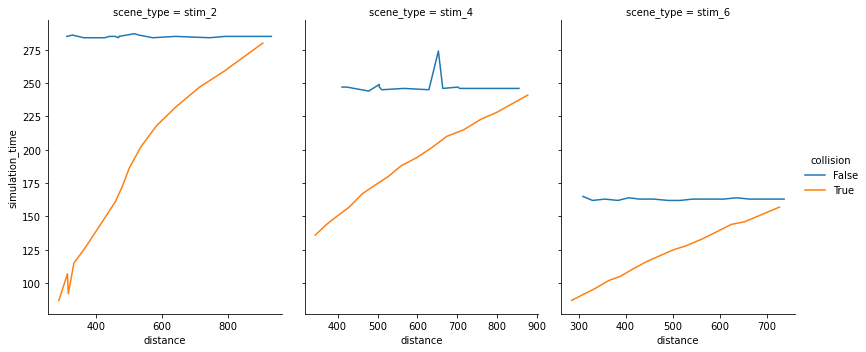

In [59]:
sns.relplot(
    data=simulation_predictions,
    x="distance", y="simulation_time",
    hue="collision",
    col="scene_type",
    kind="line",
#     col_wrap=4,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

In [ ]:
simulation_predictions = pd.DataFrame.from_dict(simulation_rt,orient='columns')
simulation_predictions['model'] = 'simulation'
abstraction_predictions = pd.DataFrame.from_dict(abstraction_rt,orient='columns')
abstraction_predictions['model'] = 'abstraction'

In [ ]:
predictions = pd.concat([abstraction_predictions,simulation_predictions])

In [ ]:
predictions = predictions.merge(distances, on ='scene')

In [ ]:
predictions = predictions.explode('simulation_time')

In [ ]:
predictions['sim_time_z'] = predictions.simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [ ]:
# Resetting the index
predictions = predictions.reset_index(drop=True)

In [ ]:
sns.relplot(
    data=predictions,
    x="distance", y="sim_time_z",
    hue="model",
    row="collision",
    col="scene_type",
    kind="line",
#     col_wrap=4,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

In [ ]:
predictions

In [ ]:
empirical_data = pd.read_json('cleaned_data_exp_4_5_6.json')

In [ ]:
empirical_data['model'] = 'empirical'

In [ ]:
empirical_data = empirical_data.loc[empirical_data.experiment_version == 4]

In [ ]:
empirical_data = empirical_data[['scene','scene_type','scene_col','part_zrt','model']]

In [ ]:
empirical_data = empirical_data.rename(columns={'scene_col':'collision','part_zrt':'sim_time_z'})

In [ ]:
empirical_data.collision = empirical_data.collision.apply(lambda x: False if x == 'no' else True)

In [ ]:
empirical_data = empirical_data.reset_index(drop=True)

In [ ]:
predictions = predictions[['scene','scene_type','collision','model','sim_time_z']]

In [ ]:
df = pd.concat([predictions,empirical_data])

In [ ]:
df = df.merge(distances, on ='scene')

In [ ]:
g = sns.relplot(
    data=df,
    x="distance", y="sim_time_z",
    hue="model", 
    col="scene_type", row="collision",
    kind="line",
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

g.figure.savefig("output.pdf")